# Normalizzazione dati inquinamento #
In questo notebook voglio provare una prima possibile applicazione di random forest per ottenere la normalizzazione dei dati sull'inquinamento relativamente alle condizioni meteorologiche, ovvero cercare un modo per scorporare l'effetto delle condizioni meteo che si sono verificate in una giornata sulla concentrazione dell'inquinante di interesse che è stata registrata. Se ne verrà verificata la validità sarà poi possibile procedere con l'applicazione del metodo per lo svolgimento delle analisi sugli effetti del traffico e l'epidemia di COVID-19.

## Introduzione a random forest ##
Random forest è un algoritmo di machine learning d'insieme, adatto a risolvere sia problemi di classificazione che di regressione. Visto che nel nostro caso quello che vogliamo stimare è una quantità, nello specifico la concentrazione di un inquinante, noi useremo la variante regressiva. Concettualmente comunque il metodo è praticamente lo stesso per entrambi i problemi, fatto salvo per alcuni dettagli minori.  
Random forest si basa sull'utilizzo di molti alberi di decisione per effettuare delle previsioni, in modo da ridurre la varianza del modello creato.  
Inoltre applicando alcune tencniche aggiuntive riesce a risolvere il problema dell'overfitting caratteristico degli alberi di decisione. Si parla di overfitting quando, dopo aver creato un modello secondo le specifiche dell'algoritmo utilizzato, se ne ottiene uno che ha buone performance sui dati usati per costruirlo ma poi risulta poco preciso quando viene messo alla prova su dati mai visti. Chiaramente questa è una situazione che si vuole evitare, poichè l'obbiettivo è quello di arrivare ad ottenere un modello le cui previsioni siano sufficentemente precise indipendentemente dai dati che gli vengono passati in input, cosa che si dovrebbe appunto ottenere con l'applicazione di random forest.  

### Definizione metodo ###
Il nostro obbiettivo è quello di riuscire a stimare un valore, nel nostro caso la concentrazione di un inquinante, partendo da un set di valori per un numero di variabili dette predittrici o features.  
È quindi chiaro che per poter fare questo tipo di lavoro sia necessario che i valori della variabile di output (la variabile che vogliamo predirre) debbano essere in qualche modo in relazione con quelli delle variabili di input (features).
Se chiamiamo $Y$ la variabile che rappresenta la concentrazione dell'inquinante di interesse ed $X$ la variabile che rappresenta i valori delle variabili di input, possiamo pensare di definire questa relazione in questo modo:
<center>$Y = f(X)$</center>
Chiaramente per noi la vera forma di $f$ è sconosciuta, poichè non possiamo conoscere tutti i fattori e le relazioni che influenzano i valori di $Y$. Possiamo però, attraverso la costruzione di un modello, creare una funzione $\hat{f}$ che sia una stima di tale funzione. La nostra definizione può quindi essere cambiata in:
<center>$\hat{Y} = \hat{f}(X)$</center>
dove $\hat{Y}$ è la variabile che rappresenta le predizioni fatte dal nostro modello (e che chiaramente vorremmo che sia il più vicino possibile ai reali valori di $Y$).

Come già accennato il modello costruito da random forest si basa sull'uso di molti alberi di decisione. Per diminuire la varianza del modello ottenuto, senza però aumentare la distorsione, viene applicata una tecnica detta bagging. Questo significa che mentre le previsioni di un singolo albero sono molto sensibili al "rumore" presente nei dati utilizzati per la sua costruzione, la media di molti alberi invece non lo è, a patto che questi alberi siano tra di loro decorrelati. Il bagging serve proprio per riuscire ad ottenere questa decorrelazione tra i vari alberi che comporranno la foresta del nostro modello.
Fare bagging significa che ogni albero verrà creato partendo da un campione estratto casualmente e con ripetizione dei dati su cui andiamo a costruire il modello. Questo significa quindi che ogni albero verrà creato sulla base di un insieme di dati diverso da quello usato per creare gli altri, ottenendo quindi la decorrelazione.

## Esempio di applicazione ##
Di seguito verrà illustrato un esempio dell'applicazione di questo metodo per provare ad ottenere la normalizzazione dei dati di un inquinante rispettivamente alle condizioni metereologiche.

Nel nostro esempio la variabile $Y$ saranno le __concentrazioni degli NOx__, e le variabili predittrici ($X$) saranno __data, precipitazioni, temperatura, direzione e velocità del vento, umidità, giorno della settimana e giorno dell'anno__. 

Chiaramente la prima cosa da fare è scegliere una stazione su cui vogliamo basare la nostra analisi d'esempio.
La stazione scelta è quella di Milano Via Zavattari, poichè possiede sensori sia per i principali inquinanti che per le variabili metereologiche che ci interessano.

Innanzitutto eseguiamo l'import dei package che saranno impiegati.

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import info_stazioni as info
import data_preparation as data_prep
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from AirNormalizer import AirNormalizer
import datetime as dt

#setto dimensioni plot matplotlib
plt.rcParams['figure.figsize'] = 10, 5

Il primo passaggio da eseguire è quello di prepararsi una tabella, a risoluzione giornaliera, in cui per ogni data saranno contenuti i valori delle osservazioni fatte per le variabili del nostro modello.
Questo è possibile tramite l'uso della funzione prepare_data, contenuta nel file data_preparation.py .
La funzione accetta come parametri:
- Id del sensore per l'inquinante
- Id del sensore per la temperatura
- Id del sensore per le precipitazioni
- Id del sensore per la direzione del vento
- Id del sensore per la velocità del vento
- Id del sensore per l'umidità
- (Opzionale) agg_unit: Unità temporale da usare per aggregare i dati ("d", "h", ..)

Dati questi parametri la funzione provvederà a creare la tabella recuperando i dati dei vari sensori dai file CSV precedentemente generati, filtrando le date per cui non si hanno valori validi per l'inquinante e riempiendo gli altri dati mancanti con la media dei valori di tale dato.

In [2]:
data = data_prep.prepare_data(6372, 5920, 9341, 19006, 19005, 6185, verbose=True)
data

,inquinante,temperatura,precipitazioni,direzione_vento,velocita_vento,umidita,day_of_year,day_of_week,epoch
Data,,,,,,,,,
1980-09-18,488.133333,13.799717,0.085468,216.788013,1.243275,66.734669,262,3,338083200000000000
1980-09-19,761.312500,13.799717,0.085468,216.788013,1.243275,66.734669,263,4,338169600000000000
1980-09-20,414.704167,13.799717,0.085468,216.788013,1.243275,66.734669,264,5,338256000000000000
1980-09-21,474.891667,13.799717,0.085468,216.788013,1.243275,66.734669,265,6,338342400000000000
1980-09-22,483.570833,13.799717,0.085468,216.788013,1.243275,66.734669,266,0,338428800000000000
...,...,...,...,...,...,...,...,...,...
2016-12-27,125.750000,12.132639,0.000000,157.540972,1.619444,67.880303,362,1,1482796800000000000
2016-12-28,148.016667,7.166667,0.000000,229.563889,0.832639,54.708333,363,2,1482883200000000000
2016-12-29,87.808333,5.859028,0.000000,130.990278,1.540278,68.527778,364,3,1482969600000000000


Visto che le rilevazioni per le variabili metereologiche iniziano dopo gli anni 2000 filtriamo la tabella in modo che contenga solo osservazioni successive a tale data, in modo da non usare troppo i valori medi con cui vengono rimpiazzati i valori mancanti dalla funzione.

In [3]:
data = data[data.index >= '2000-01-01']
data

,inquinante,temperatura,precipitazioni,direzione_vento,velocita_vento,umidita,day_of_year,day_of_week,epoch
Data,,,,,,,,,
2000-01-01,447.433333,0.354167,0.085468,216.788013,1.243275,66.734669,1,5,946684800000000000
2000-01-02,346.137500,0.366667,0.085468,216.788013,1.243275,66.734669,2,6,946771200000000000
2000-01-03,549.454167,0.370833,0.085468,216.788013,1.243275,66.734669,3,0,946857600000000000
2000-01-04,673.245833,1.791667,0.085468,216.788013,1.243275,66.734669,4,1,946944000000000000
2000-01-05,819.020833,3.520833,0.085468,216.788013,1.243275,66.734669,5,2,947030400000000000
...,...,...,...,...,...,...,...,...,...
2016-12-27,125.750000,12.132639,0.000000,157.540972,1.619444,67.880303,362,1,1482796800000000000
2016-12-28,148.016667,7.166667,0.000000,229.563889,0.832639,54.708333,363,2,1482883200000000000
2016-12-29,87.808333,5.859028,0.000000,130.990278,1.540278,68.527778,364,3,1482969600000000000


Il nostro dataset quindi consiste di 6072 osservazioni per il periodo dal 01-01-2000 al 31-12-2016.

Prima di iniziare dichiariamo una serie di funzioni che saranno utili nella valutazione del modello.
- rf_feat_importance serve per creare la tabella con l'importanza delle variabili predittrici 
- evaluate_training ci dà una serie di metriche per misurare le performance del nostro modello durante la fase di costruzione
- evaluate_testing ci dà una serie di metriche per misurare le performance del nostro modello sul test set (quindi su dati nuovi che non avevo mai visto prima)

I loro risultati saranno approfonditi successivamente.

In [4]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def evaluate_training(model, x_train, y_train):
    y_pred_train = model.predict(x_train)
    mse = metrics.mean_squared_error(y_train, y_pred_train)
    print("Training:")
    print("MSE:", mse)
    print("RMSE:", np.sqrt(mse))
    print("OOB Score (R^2):", model.oob_score_)
    
def evaluate_testing(model, x_test, y_test):
    y_pred = model.predict(x_test)
    mse = metrics.mean_squared_error(y_test, y_pred)
    print("Testing:")
    print("MSE:", mse)
    print("RMSE:", np.sqrt(mse)) 
    print("R^2 for testing:", model.score(x_test, y_test))

## Creazione del modello ##
Ora che abbiamo a disposizione i nostri dati possiamo passare a creare il modello che poi andremo ad usare per ottenere i valori dell'inquinante normalizzati.

Come prima operazione è necessario estratte da questa tabella i valori della variabile da predirre (la nostra $X$) e i valori delle variabili predittrici ($Y$).
Queste due variabili vengono poi ulteriormente divise attraverso l'uso della funzione train_test_split. Questa funzione, contenuta nel package scikit-learn, dividerà x e y in due gruppi ciascuno, che chiameremo training set e test set, assegnando in modo casuale al training set l'80% delle osservazioni totali (come specificato dal parametro train_size).
Questa operazione è fatta in modo da avere una parte di dati che sarà usata per la costruzione del modello (il training set) e una che sarà usata per verificare le performance del modello (il test set). Questo tipo di approccio alla costruzione/validazione di modelli è detto il "validation set approach".

In [5]:
y = data.inquinante
x = data.drop("inquinante", 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = .8, random_state = 123)

Ora che abbiamo diviso i nostri dati siamo finalmente pronti a creare il modello. L'algoritmo di random forest ha una serie di iperparametri settabili; inizialmente l'unico che andiamo a fissare è il numero di alberi da creare nella foresta, che per ora settiamo a 100. Il parametro oob_score serve per indicare di calcolare lo score del modello sui dati out of bag, mentre random_state serve per specificare il seed da usare per le operazioni casuali e, se settato, rendere quindi l'esperimento riproducibile.

**Dati Out Of Bag**  
Come descritto in precedenza ogni albero della foresta viene creato attrraverso l'applicazione del bagging, ovvero estrando un subset casuale dai dati di partenza. In questo subset non è assolutamente detto che siano contenute tutte le osservazioni presenti nei dati originali (anzi, è quello che vorremmo evitare per decorrelare i vari alberi) di cui infatti in media non vengono usate il 30% delle osservazioni.  
Ogni albero quindi avrà una parte di dati che non saranno stati usati nella sua creazione e che possono perciò essere utilizzati per testare le sue performance: questi dati vengono detti Out Of Bag. 
La descrizione di come vengono usati questi dati per testare le performance del modello sarà data più avanti, quando andremo a valutare i risultati ottenuti nel nostro esperimento.

Andiamo quindi a creare il nostro modello passandogli i dati contenuti nel training set. Una volta creato useremo le due funzioni dichiarate in precedenza per valutare il modello durante la fase di training e quella di testing.

In [6]:
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=123)
model.fit(x_train, y_train)

evaluate_training(model, x_train, y_train)
evaluate_testing(model, x_test, y_test)

Training:
MSE: 664.2315578677553
RMSE: 25.77269015581717
OOB Score (R^2): 0.6984649491734505
Testing:
MSE: 5076.298448746311
RMSE: 71.24814698465013
R^2 for testing: 0.6999967947469763


Le metriche usate per la valutazione del modello, sia nella fase di training (costruzione) che in quella di testing (valutazione delle sue performance) sono le seguenti:
1. **MSE: Mean Squared Error**  
    Chiamiamo $Y_i$ il valore della variabile $Y$ per l'i-esima osservazione e $\hat{Y_i}$ il valore della predizione fatta dal nostro modello per l'i-esima osservazione. Allora, se $n$ è il numero totale delle osservazioni presenti nei nostri dati      
    <center>$MSE = \frac{1}{n}\sum_{i=1}^{n} (Y_i - \hat{Y_i})^2$</center>
    
    Chiaramente più il nostro modello sarà preciso e più questo valore si avvicinerà allo 0.
2. **RMSE: Root Mean Squared Error** 
    <center>$RMSE = \sqrt{MSE}$</center>
    
    Non è altro che la radice quadrate del MSE. Questo indice ha il vantaggio di essere espresso con la stessa unità di misura della variabile da predirre
3. **OOB Score / $R^2$** 
    Nel contesto dei metodi statistici il cui obbiettivo è fare delle previsioni, il coefficiente $R^2$ ci indica quanto bene il nostro modello rappresenta i dati osservati, basandosi sulla proporzione di varianza spiegata dal modello.  
    Il coefficiente viene così calcolato:  
    <center>$R^2 = \frac{\sum_{i=1}^{n} (Y_i - \hat{Y_i})^2}{\sum_{i=1}^{n} (Y_i - \overline{Y_i})^2}$</center>  
    
    Dove $\overline{Y_i}$ è la media dei valori di Y.<br/>
    Per quanto riguarda l'OOB Score il procedimento ottenuto per calcolarlo è lo stesso, ma al posto che usare l'intera foresta per fare una previsione, per ogni osservazione vengono fatte fare le previsioni solo a quegli alberi per cui tale osservazione risulta OOB. Così facendo si può quindi ottenere una stima di quello che sarà il test error del nostro modello. Notare infatti come il valore dell'OOB Score calcolato nella fase di training sia vicino al valore di $R^2$ ottenuto testando il modello.<br/> 
    Questi indici normalmente assumono valori tra 0 e 1.
    
Il valore del coefficiente $R^2$ per il modello appena costruito è di 0.7, che è un valore accettabile. Chiaramente poi si potrà lavorare per capire se si può migliorare ulteriormente.

Poter usare l'OOB Score del nostro modello per stimare il valore del coefficiente $R^2$ ci permetterà di poter evitare la divisione in training e testing set dei nostri dati originali, potendo così costruire il modello sfruttando tutte le osservazioni a disposizione e riuscendo comunque a valutarne le performance.

## Importanza delle variabili ##
Uno dei vantaggi dati dall'applicazione di random forest è quello di poter analizzare l'importanza delle variabili usate per le nostre predizioni, in modo da capire quali siano le più influenti.
Le variabili più importanti sono chiaramente quelle che influiscono maggiormente sulla variabile da predirre, ovvero quelle che al cambiare del loro valore fanno cambiare maggiormente anche il risultato della previsione.

In [7]:
rf_feat_importance(model, x_train)

,cols,imp
5,day_of_year,0.341430
0,temperatura,0.265294
7,epoch,0.237087
6,day_of_week,0.063919
4,umidita,0.050034
3,velocita_vento,0.020377
1,precipitazioni,0.014018
2,direzione_vento,0.007840


Come si può vedere il giorno dell'anno risulta la variabile più influente, cosa che non risulta per niente sorprendente se consideriamo la stagionalità degli NOx. Le altre variabili importanti sono la temperatura e la data, a significare che il passare del tempo ha influito molto sui valori registrati. Anche questa osservazione non dovrebbe sorprenderci, visto che è noto come gli inquinanti abbiano tutti dei trend in calo nel corso degli ultimi anni.  
Le restanti variabili sembrano avere un'importanza piuttosto limitata, forse anche a causa del numero elevato di valori mancanti nel dataset, che poi sono riempiti con la media, per le osservazioni di tali grandezze.

## Partial dependence plots ##
Un'altra analisi che si può fare sul modello e sulle variabili usate per effettuare le previsioni è quella tramite l'uso dei partial dependence plots. Viene generato un grafico per ogni variabile predittrice usata nel nostro modello ed ognuno sarà la rappresentazione di come cambiano i valori di $Y$ al cambiare di tale variabile predittrice se si lasciano le altre fissate al loro valore medio.

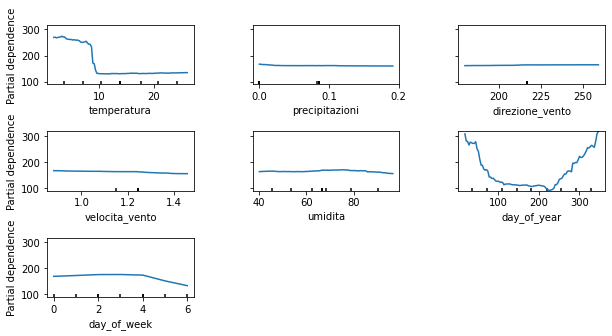

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]

plot_partial_dependence(model, x_train, x_train.columns.drop("epoch"), )
fig = plt.gcf()
fig.subplots_adjust(wspace=0.4, hspace=0.8)

Osservando i grafici è facile capire come cambi il valore della concentrazione di inquinante al variare delle diverse variabili. Per esempio è molto evidente come i valori più alti siano registrati nella stagione invernale o, comunque, quando si registrano temperature al di sotto dei 10 gradi.

## Normalizzazione dei dati ##
Come avevo già descritto precedentemente il processo per ottenere il valore della concentrazione di un inquinante per una data consiste nel far fare al nostro modello 1000 previsioni per tale data, ma con tutte le altre variabili che cambiano casualmente di previsione in previsione, calcolandone infine la media.  
La funzione normalize_timeseries(), definita nel file AirNormalizer.py, applica questo processo a tutte le date presenti nel dataset iniziale, in modo da poter ottenere la timeseries normalizzata per l'inquinante di interesse.

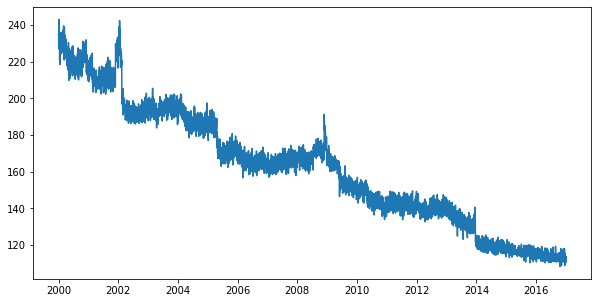

In [9]:
normalizer = AirNormalizer(data)
normalized = normalizer.normalize_timeseries()
plt.plot(normalized.index, normalized.inquinante)
plt.show()

Quella ottenuta è quindi la timeseries normalizzata degli NOx per la stazione di Milano Via Zavattari; come si può vedere viene confermata la presenza di un trend negativo che in questa timeseries risulta però molto più evidente che dai dati "grezzi". 
Avendo a disposizione i dati normalizzati sarà poi possibile effettuare le analisi previste relative a blocchi del traffico ed epidemia COVID-19.

Da questa prima prova risulta quindi possibile anche nel nostro caso applicare random forest per ottenere la normalizzazione dei dati di un inquinante, come già fatto da altri studi precedenti, ed infatti sia i risultati ottenuti che le performance del modello creato risultano similari e compatibili. [Ref #1](https://www.atmos-chem-phys.net/18/6223/2018/acp-18-6223-2018.pdf) [Ref #2](https://www.sciencedirect.com/science/article/pii/S004896971834244X)

## Miglioramenti applicabili ##
Prima di procedere all'utilizzo di questo metodo per lo svolgimento delle analisi successive credo sia utile fare un po' di esperimenti per vedere se è possibile migliorare ulteriormente le performance del modello ottenuto e per capire come utilizzarlo a seconda del caso d'interesse.

### Testing iperparametri ###
La prima attività che può risultare utile è fare un po' di testing sui valori degli iperparametri di random forest, per cercare di capire quale combinazione possa risultare più efficace.  
Per primo andremo a testare il parametro n_estimators, che indica il numero di alberi creato nella foresta.  
Definiamo quindi una funzione che se ne occupi.

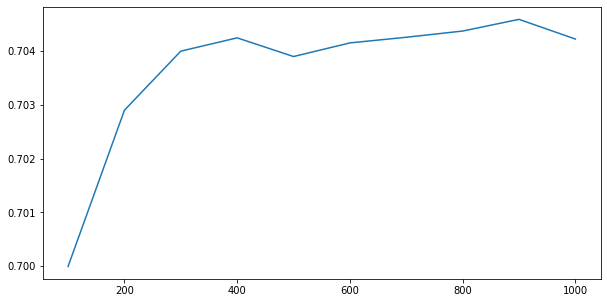

In [10]:
def test_estimators():
    n_est = np.arange(100, 1001, 100)
    results = pd.DataFrame(columns=["n", "rmse", "r2"])
    for n in n_est:
        #print(f"Testing with {n} estimators")
        model = RandomForestRegressor(n_estimators=n, oob_score=True, random_state=123)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = model.score(x_test, y_test)
        results.loc[len(results)] = [n, np.sqrt(mse), r2]
    return results
        
results = test_estimators()
plt.plot(results.n, results.r2)
plt.show()

Sembra che il numero di alberi usati nella foresta sia poco influente sul valore di $R^2$, comunque 300 mi sembra la scelta migliore come compromesso prestazioni/performance. 
Possiamo anche controllare come si comporta il RMSE al variare di questo parametro.

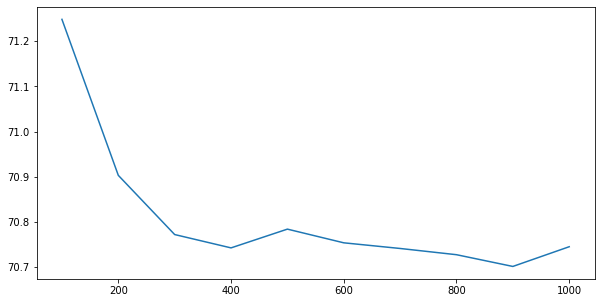

In [11]:
plt.plot(results.n, results.rmse)
plt.show()

Anche per quanto riguarda questo aspetto sembra che 300 sia la scelta migliore, visto che, chiaramente, minore è l'errore medio del nostro modello e megliori sono le sue performance.

Un altro iperparametro che può valer la pena testare è sicuramente max_depth, che stabilisce la profondità massima degli alberi che comporranno la foresta. Definiamo una funzione analoga alla precedente che se ne occupi.

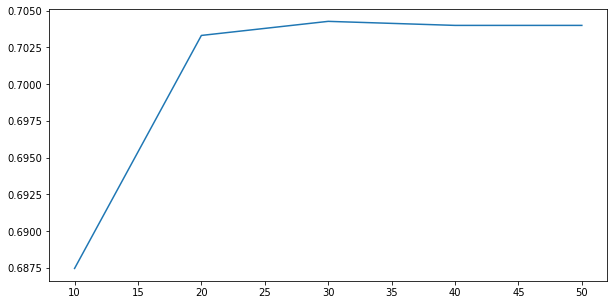

In [12]:
def test_depth():
    depths = np.arange(10, 51, 10)
    results = pd.DataFrame(columns=["depth", "rmse", "r2"])
    for depth in depths:
        #print(f"Testing with max depth value set to {depth}")
        model = RandomForestRegressor(n_estimators=300, max_depth=depth, oob_score=True, random_state=123)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = model.score(x_test, y_test)
        results.loc[len(results)] = [depth, np.sqrt(mse), r2]
    return results

results = test_depth()
plt.plot(results.depth, results.r2)
plt.show()

Sembra che anche questo parametro abbia relativamente poca influenza sulle prestazioni del modello, un valore compreso tra 20 e 30 dovrebbe essere la scelta migliore.

L'ultimo iperparametro che vale la pena verificare è max_features, ovvero il numero massimo di variabili utilizzabili dalla condizione che viene posta nei nodi interni degli alberi della nostra foresta.  
Definiamo una funzione analoga che se ne occupi come già fatto precedentemente.

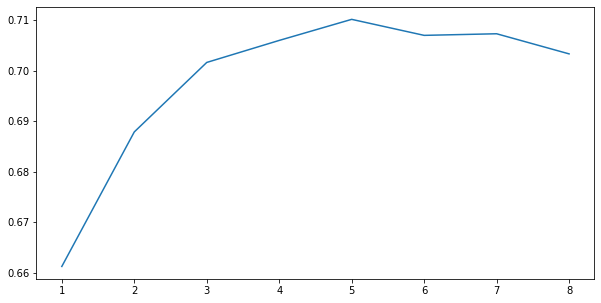

In [13]:
def test_features():
    features = np.arange(1, 9, 1)
    results = pd.DataFrame(columns=["features", "rmse", "r2"])
    for feat in features:
        #print(f"Testing with max depth value set to {depth}")
        model = RandomForestRegressor(n_estimators=300, max_depth=20, max_features=feat, oob_score=True, random_state=123)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = model.score(x_test, y_test)
        results.loc[len(results)] = [feat, np.sqrt(mse), r2]
    return results

results = test_features()
plt.plot(results.features, results.r2)
plt.show()

Per quanto riguarda questo parametro sembra che 5 sia il valore migliore, che quindi andremo ad utilizzare.

### Aggregazione dati su base oraria ###
Usare i dati aggregati su base giornaliera per creare il nostro modello ha sicuramente il vantaggio di poter estendere il periodo considerato durante l'analisi senza però andare ad aumentare eccessivamente la quantità di dati ed elaborazioni richieste. Può esserci però la necessità di fare analisi su periodi più brevi e a quel punto potrebbe essere più utile aggregare i dati su base oraria per riuscire lo stesso ad avere una buona quantità di dati su cui basare la costruzione del modello.  

A questo punto credo che sia quindi utile fare un esperimento, provando a generare la timeseries normalizzata degli anni 2011-2016 (gli ultimi 5 anni per cui abbiamo a disposizione tutti i dati necessari) ma basandosi su dati orari, per poi confrontarla con quanto ottenuto in precedenza e verificare se si possono notare differenze.

**Da qui in poi per eseguire tutte le operazioni legate alla normalizzazione verrà fatto uso della classe AirNormalizer, appositamente scritta per gestire la questione. Le attività da svolgere rimangono comunque invariate a quanto visto in precedenza.**

In [14]:
data_hour = data_prep.prepare_data(6372, 5920, 9341, 19006, 19005, 6185, agg_unit="h")
data_hour = data_hour[data_hour.index > '2011-01-01'] #filtro gli anni 2011-2016
print(len(data_hour), "osservazioni nel dataset")
normalizer_hour = AirNormalizer(data_hour)
print(normalizer_hour.evaluate_training())
print(normalizer_hour.evaluate_testing())

49989 osservazioni nel dataset
MSE          738.238105
RMSE          27.170537
OOB Score      0.786710
dtype: float64
MSE     3335.289488
RMSE      57.751965
R2         0.787150
dtype: float64


Come si può vedere dai valori degli indici mostrati il modello ottenuto risulta migliore del precedente, con un indice $R^2$ vicino a 0.8, che solitamente viene indicato come valore target di un buon modello. Anche il valore di RMSE è passato da 71 a 57, facendo registrare un calo del circa 20%. 

Sicuramente il fatto di avere a disposizione quasi 10 volte tante osservazioni rispetto al dataset precedente può essere una delle principali cause di questo miglioramento ottenuto.

Andiamo ora a generare la nuova timeseries normalizzata e proviamo a confrontarla con quanto ottenuto in precedenza per vedere se si possono notare differenze da questo aumento di precisione ottenuto.

Making prediction 0
Making prediction 10
Making prediction 20
Making prediction 30
Making prediction 40
Making prediction 50
Making prediction 60
Making prediction 70
Making prediction 80
Making prediction 90
Making prediction 100
Making prediction 110
Making prediction 120
Making prediction 130
Making prediction 140
Making prediction 150
Making prediction 160
Making prediction 170
Making prediction 180
Making prediction 190
Making prediction 200
Making prediction 210
Making prediction 220
Making prediction 230
Making prediction 240
Making prediction 250
Making prediction 260
Making prediction 270
Making prediction 280
Making prediction 290


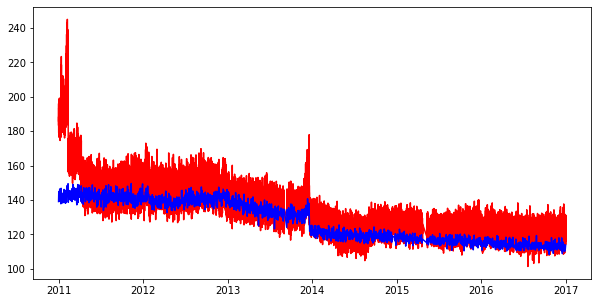

In [15]:
normalized_hour = normalizer_hour.normalize_timeseries(n_preds=300, verbose=True)
plt.plot(normalized_hour.index, normalized_hour.inquinante, color="red")
plt.plot(normalized[normalized.index >= '2011-01-01'].index, normalized[normalized.index >= '2011-01-01'].inquinante, color="blue")
plt.show()

I risultati ottenuti sembrano essere abbastanza compatibili, anche se il modello creato sui dati aggregati per ora risulta essere più soggetto al "rumore", forse anche a causa del minor numero di previsioni utilizzate per ottenere il valore normalizzato. 
Proviamo a calcolare le medie mensili di entrambe le timeseries così da poterle confrontare.

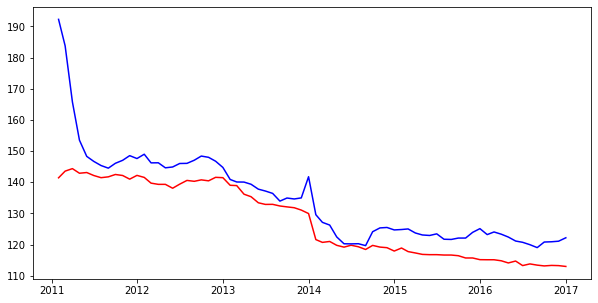

In [16]:
tmp1 = normalized.groupby(pd.Grouper(freq="M")).mean()
tmp2 = normalized_hour.groupby(pd.Grouper(freq="M")).mean()
plt.plot(tmp1[tmp1.index >= '2011-01-01'].index, tmp1[tmp1.index >= '2011-01-01'].inquinante, color="red")
plt.plot(tmp2.index, tmp2.inquinante, color="blue")
plt.show()

Anche in questo caso i risultati ottenuti sembrano essere compatibili e si è riusciti ad eliminare l'eccessivo rumore presente nel secondo modello, a conferma della validità di entrambe le alternative. Si potrà quindi scegliere quale utilizzare a seconda del caso, usando l'ora quando si considerano periodi brevi ed il giorno per quelli più estesi.

Proviamo ad analizzare i partial dependence plots e le feature importances anche del nuovo modello.

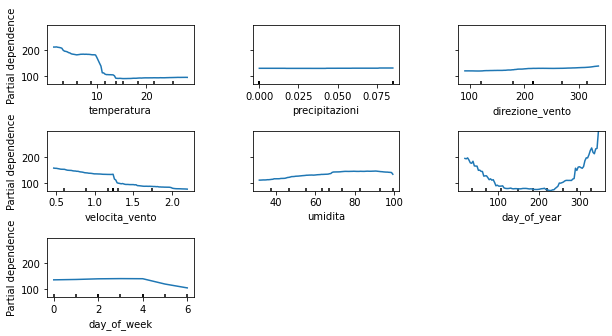

In [17]:
train_hour = normalizer_hour.get_trainingset()

plot_partial_dependence(normalizer_hour.get_model(), train_hour, train_hour.columns.drop("epoch"), )
fig = plt.gcf()
fig.subplots_adjust(wspace=0.4, hspace=0.8)

In [18]:
normalizer_hour.feature_importance()

,cols,imp
0,temperatura,0.250933
5,day_of_year,0.238598
7,epoch,0.226774
4,umidita,0.104521
3,velocita_vento,0.077202
6,day_of_week,0.052509
2,direzione_vento,0.037656
1,precipitazioni,0.011809


Anche questi risultati sono compatibili con quelli del precedente modello, a dimostrare come entrambi si siano creati un "quadro della situazione" molto simile, individuando relazioni simili tra le variabili.

## Sommario ##
In questa prima fase si è quindi visto come sia possibile applicare la tecnica di random forest per ottenere la normalizzazione dei dati sull'inquinamento atmosferico. Nei prossimi giorni proverò a valutare quali eventuali miglioramenti si possono provare ad introdurre, così da poter poi passare ad affrontare le analisi successive con un metodo ben "consolidato".

# Ulteriori approfondimenti #

## Sperimentazione con PM10 ##
Nell'esempio precedente ci siamo occupati degli NOx, ottenendo dei risultati soddisfacenti dai modelli creati. Ora però vorrei provare a fare la stessa cosa, ma questa volta occupandomi del PM10 rilevato dalla stazione di Milano Via Senato. Sono curioso di fare questa sperimentazione perchè le polveri sottili rientrano tra quegli inquinanti che sono molto influenzati anche da processi meteorologici più su larga scala (altezza dello strato di rimescolamento, movimenti delle masse d'aria, ecc..) e quindi voglio testare come si comporta il nostro metodo trattando questo inquinante.

La stazione di Milano via Senato purtroppo non ha i sensori delle variabili meteorologiche, perciò verranno usati i valori rilevati dalla stazione di Lambrate.
I passi da seguire sono sempre gli stessi illustrati precedentemente.

In [2]:
data_pm = data_prep.prepare_data(10320, 2001, 2006, 14390, 14391, 2002)
data_pm

,inquinante,temperatura,precipitazioni,direzione_vento,velocita_vento,umidita,day_of_year,day_of_week,epoch
Data,,,,,,,,,
2007-08-10,17.0,11.416508,0.020785,193.681364,1.352058,79.513027,222,4,1186704000000000000
2007-08-11,22.0,11.416508,0.020785,193.681364,1.352058,79.513027,223,5,1186790400000000000
2007-08-12,22.0,11.416508,0.020785,193.681364,1.352058,79.513027,224,6,1186876800000000000
2007-08-13,25.0,11.416508,0.020785,193.681364,1.352058,79.513027,225,0,1186963200000000000
2007-08-14,26.0,11.416508,0.020785,193.681364,1.352058,79.513027,226,1,1187049600000000000
...,...,...,...,...,...,...,...,...,...
2020-05-19,20.0,11.416508,0.020785,193.681364,1.352058,79.513027,140,1,1589846400000000000
2020-05-21,22.0,11.416508,0.020785,193.681364,1.352058,79.513027,142,3,1590019200000000000
2020-05-22,30.0,11.416508,0.020785,193.681364,1.352058,79.513027,143,4,1590105600000000000


In [6]:
normalizer = AirNormalizer(data_pm)
normalizer.evaluate_testing()

MSE     309.509522
RMSE     17.592883
R2        0.580579
dtype: float64

Questa volta abbiamo ottenuto un modello meno preciso di quanto riuscivamo a fare trattando gli NOx. Potrebbe essere una semplice casualità, ma credo che la cosa sia legata anche ad altri due fattori: il primo può essere il minor numero di osservazioni che si hanno a disposizione, il secondo è che, probabilmente, con le variabili a disposizione non si riescono ad identificare bene tutti i fenomeni meteorologici di cui accennavo prima e che influenzano le concentrazioni di PM10.

Proviamo comunque a generare la timeseries normalizzata, per verificare cosa otteniamo.

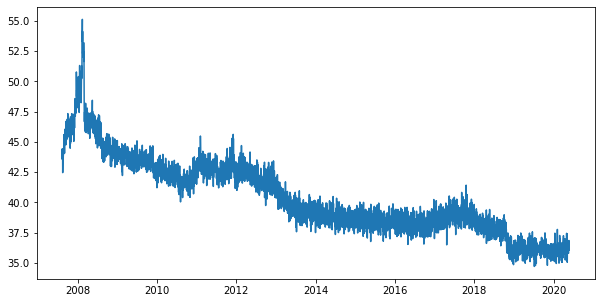

In [7]:
norm = normalizer.normalize_timeseries()
plt.plot(norm.index, norm.inquinante)
plt.show()

Un possibile miglioramento che si potrebbe provare ad applicare sarebbe l'introduzione di ulteriori variabili che aiutino il nostro modello ad identificare meglio i fenomeni che influenzano le concentrazioni e, quindi, anche a fare previsioni più precise. Una di quelle che si possono provare a considerare è la radiazione globale, misurata sempre presso la stazione di Lambrate.
Possiamo quindi importare le rilevazioni di tale sensore, unirle alla tabella creata precedentemente e provare a creare un nuovo modello per vedere come cambia la situazione.

In [3]:
rad = pd.read_csv("../data/sensori_meteo_csv/2008.csv", parse_dates=["Data"], index_col="Data", dayfirst=True)
rad = rad.groupby(pd.Grouper(freq="d")).mean()
rad = rad.loc[rad.Valore >= 0, ["Valore"]]
rad = rad.rename(columns = {"Valore": "radiazione"})
rad = rad.fillna(rad.mean())
rad

,radiazione
Data,
2003-09-12,277.188235
2003-09-16,253.222222
2003-09-17,246.305556
2003-09-18,251.966667
2003-09-19,191.452174
...,...
2020-04-27,133.951389
2020-04-28,147.069444
2020-04-29,298.368056


In [65]:
newdata = data_pm.join(rad, how="left")
newdata.radiazione = newdata.radiazione.fillna(newdata.radiazione.mean())
newdata

,inquinante,temperatura,precipitazioni,direzione_vento,velocita_vento,umidita,day_of_year,day_of_week,epoch,radiazione
Data,,,,,,,,,,
2007-08-10,17.0,11.416508,0.020785,193.681364,1.352058,79.513027,222,4,1186704000000000000,151.546233
2007-08-11,22.0,11.416508,0.020785,193.681364,1.352058,79.513027,223,5,1186790400000000000,151.546233
2007-08-12,22.0,11.416508,0.020785,193.681364,1.352058,79.513027,224,6,1186876800000000000,151.546233
2007-08-13,25.0,11.416508,0.020785,193.681364,1.352058,79.513027,225,0,1186963200000000000,151.546233
2007-08-14,26.0,11.416508,0.020785,193.681364,1.352058,79.513027,226,1,1187049600000000000,151.546233
...,...,...,...,...,...,...,...,...,...,...
2020-05-19,20.0,11.416508,0.020785,193.681364,1.352058,79.513027,140,1,1589846400000000000,151.546233
2020-05-21,22.0,11.416508,0.020785,193.681364,1.352058,79.513027,142,3,1590019200000000000,151.546233
2020-05-22,30.0,11.416508,0.020785,193.681364,1.352058,79.513027,143,4,1590105600000000000,151.546233


In [49]:
newnorm = AirNormalizer(newdata)
print(newnorm.evaluate_training())
print(newnorm.evaluate_testing())

MSE          37.668795
RMSE          6.137491
OOB Score     0.610495
dtype: float64
MSE     293.229608
RMSE     17.123948
R2        0.602640
dtype: float64


I miglioramenti ottenuti alle prestazioni del modello rispetto alla soluzione precedente risultano comunque piuttosto limitati.  
Proviamo ad analizzare anche l'importanza delle variabili, per capire quanto sia usata nel fare previsioni.

In [43]:
newnorm.feature_importance()

,cols,imp
5,day_of_year,0.254614
0,temperatura,0.237965
7,epoch,0.144889
8,radiazione,0.117711
4,umidita,0.072000
3,velocita_vento,0.064725
6,day_of_week,0.041485
1,precipitazioni,0.033834
2,direzione_vento,0.032778


Alla radiazione viene comunque attribuita un po' d'importanza, segnale che il modello riesca ad utilizzarla per fare le sue previsioni, anche se poi non risultano così più precise di quanto ottenuto in precedenza.

Proviamo ad analizzare anche i partial dependence plots.

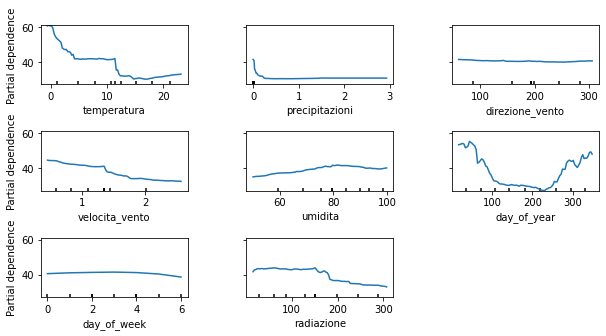

In [102]:
train_newnorm = newnorm.get_trainingset()

plot_partial_dependence(newnorm.get_model(), train_newnorm, train_newnorm.columns.drop("epoch"), )
fig = plt.gcf()
fig.subplots_adjust(wspace=0.4, hspace=0.8)

Dal grafico relativo alla radiazione solare si nota come per valori superiori al 150 (circa) la concentrazione dell'inquinante inizi a calare sensibilmente, mostrando quindi l'esistenza di una relazione tra i valori delle due variabili.  
Credo quindi che nel corso delle nostre analisi, se l'avremo a disposizione, si potrà utilizzare anche questa misura tra le nostre variabili predittrici.

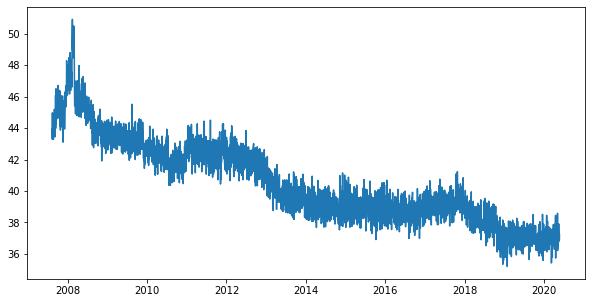

In [58]:
newnorm_ts = newnorm.normalize_timeseries()
plt.plot(newnorm_ts.index, newnorm_ts.inquinante)
plt.show()

Confrontando quanto ottenuto con i risultati precedenti non si notano grosse differenze, a conferma del fatto che, comunque, l'uso della radizione non abbia stravolto le previsioni fatte dal nostro modello.

## Considerazioni precipitazioni ##
**Update: la variabile 'pioggia' non viene più utilizzata nel processo, il conteggio dei giorni dalle ultime precipitazioni registrate invece si**

In tutti i modelli creati l'importanza della misura delle precipitazioni è sempre risultata molto limitata, cosa che sorprende poichè è noto come nella realtà sia un aspetto molto influente sulle concentrazioni registrate. Credo sia quindi utili fare un paio di prove per valutare se eventualmente si può utilizzare in modo più efficace anche questa misura.

Per fare le prove saranno usati ancora gli stessi dati usati in precedenza, relativi alle concentrazioni di PM10 registrate dalla stazione di Milano via Senato. Visto che per il primo periodo considerato i dati delle precipitazioni non sono disponibili (e sono quindi stati riempiti col valore medio della variabile) prima di iniziare andiamo a filtrare i record perchè contengano solo dati a partire dal 2010 in poi, in modo da lavorare con dati reali.

In [53]:
prec = newdata[newdata.index >= '2010-01-01']
prec

,inquinante,temperatura,precipitazioni,direzione_vento,velocita_vento,umidita,day_of_year,day_of_week,epoch,radiazione
Data,,,,,,,,,,
2010-01-01,82.0,1.566667,0.000000,193.681364,1.352058,100.000000,1,4,1262304000000000000,18.573427
2010-01-02,22.0,-0.050000,0.000000,193.681364,1.352058,100.000000,2,5,1262390400000000000,85.625000
2010-01-03,20.0,0.616667,0.000000,193.681364,1.352058,22.133333,3,6,1262476800000000000,35.986111
2010-01-06,62.0,-1.083333,0.000000,193.681364,1.352058,76.416667,6,2,1262736000000000000,56.888889
2010-01-07,86.0,0.050000,0.000000,193.681364,1.352058,89.450000,7,3,1262822400000000000,51.090278
...,...,...,...,...,...,...,...,...,...,...
2020-05-19,20.0,11.416508,0.020785,193.681364,1.352058,79.513027,140,1,1589846400000000000,151.546233
2020-05-21,22.0,11.416508,0.020785,193.681364,1.352058,79.513027,142,3,1590019200000000000,151.546233
2020-05-22,30.0,11.416508,0.020785,193.681364,1.352058,79.513027,143,4,1590105600000000000,151.546233


Per inquadrare bene la situazione credo sia utile indagare su che tipo di relazione esista tra la misura delle precipitazioni e quella dell'inquinante. Andiamo a generare quindi uno scatter plot che ci permetta di verificare questo aspetto.

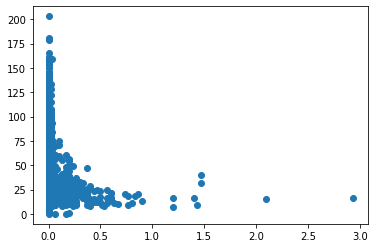

In [54]:
plt.scatter(prec.precipitazioni, prec.inquinante)
plt.show()

Guardando il grafico si nota come basti la minima quantità di precipitazioni per abbattere sensibilmente le concentrazioni registrate. Per il nostro modello potremmo quindi pensare di introdurre una nuova variabile (che sarà chiamata 'pioggia') che ci indichi se per un giorno sono state registrate precipitazioni, da affiancare a quella già utilizzata.  
Andiamo quindi a modificare la nostra tabella di dati per inserire questa nuova variabile e procediamo con la creazione di un nuovo modello per testarne le performance.

In [57]:
#se precipitazioni > 0 true, altrimenti false
prec["pioggia"] = np.where(prec["precipitazioni"]>0, True, False)
norm_prec = AirNormalizer(prec)
print(norm_prec.evaluate_training())
print(norm_prec.evaluate_testing())

/home/marco/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MSE          35.520056
RMSE          5.959870
OOB Score     0.612239
dtype: float64
MSE     245.247246
RMSE     15.660372
R2        0.611949
dtype: float64


In [58]:
norm_prec.feature_importance()

,cols,imp
0,temperatura,0.284240
5,day_of_year,0.208105
8,radiazione,0.132111
7,epoch,0.097682
4,umidita,0.086075
3,velocita_vento,0.078510
2,direzione_vento,0.042877
6,day_of_week,0.030997
1,precipitazioni,0.028707
9,pioggia,0.010695


Vediamo che anche in questo caso però alla nuova variabile è attribuita la stessa minima importanza che viene attribuita alle precipitazioni.  
Anche se il coefficiente $R^2$ risulta ancora vicino a quanto ottenuto in precedenza, l'$RMSE$ risulta calato di circa 1.5 a significare che il nostro modello è stato capace di fare previsioni mediamente più precise. Credo che quindi per il nostro processo di normalizzazione sia sensato utilizzare sempre anche questa variabile, anche perchè può essere calcolata molto semplicemente senza necessità di grandi elaborazioni.

Un'altra possibilità, legata al fatto che non avere precipitazioni per diversi giorni consecutivi porti sicuramente ad innalzamenti delle concentrazioni registrate, è quella di inserire nel nostro modello una variabile che sia il conteggio dei giorni trascorsi dall'ultima volta che sono state registrate precipitazioni per la località considerata.

Il seguente codice si occupa di calcolare ed aggiungere alla tabella dei dati anche questa variabile così che si possa poi creare un nuovo modello per valutare se l'introduzione abbia portato dei benefici.  

**Nota**: Purtroppo questo tipo di approccio è un po' debole rispetto ai dati mancanti. Infatti i giorni per cui risulta mancante la misura delle precipitazioni vengono "riempiti" col valore medio di tutte le osservazioni, che però è sicuramente >0 e quindi questo valore verrà riconosciuto come quello di un giorno in cui sono state registrate precipitazioni. Fortunatamente la misura risulta comunque disponibile per gran parte delle giornate considerate.

In [59]:
count = 0
for index, row in prec.iterrows():
    if(row.precipitazioni > 0):
        count = 0
    prec.loc[index, "giorni_senza_pioggia"] = count
    count += 1

prec

/home/marco/.local/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/marco/.local/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,inquinante,temperatura,precipitazioni,direzione_vento,velocita_vento,umidita,day_of_year,day_of_week,epoch,radiazione,pioggia,giorni_senza_pioggia
Data,,,,,,,,,,,,
2010-01-01,82.0,1.566667,0.000000,193.681364,1.352058,100.000000,1,4,1262304000000000000,18.573427,False,0.0
2010-01-02,22.0,-0.050000,0.000000,193.681364,1.352058,100.000000,2,5,1262390400000000000,85.625000,False,1.0
2010-01-03,20.0,0.616667,0.000000,193.681364,1.352058,22.133333,3,6,1262476800000000000,35.986111,False,2.0
2010-01-06,62.0,-1.083333,0.000000,193.681364,1.352058,76.416667,6,2,1262736000000000000,56.888889,False,3.0
2010-01-07,86.0,0.050000,0.000000,193.681364,1.352058,89.450000,7,3,1262822400000000000,51.090278,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-19,20.0,11.416508,0.020785,193.681364,1.352058,79.513027,140,1,1589846400000000000,151.546233,True,0.0
2020-05-21,22.0,11.416508,0.020785,193.681364,1.352058,79.513027,142,3,1590019200000000000,151.546233,True,0.0
2020-05-22,30.0,11.416508,0.020785,193.681364,1.352058,79.513027,143,4,1590105600000000000,151.546233,True,0.0


Ora che abbiamo preparato i dati proviamo a controllare tramite un grafico di dispersione se già ad occhio possono essere notate delle relazioni tra la variabile appena introdotta e le concentrazioni registrate per l'inquinante.

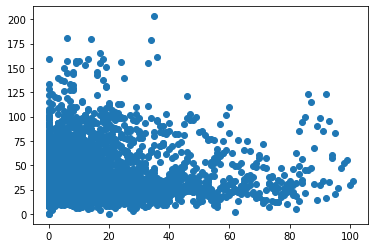

In [60]:
plt.scatter(prec.giorni_senza_pioggia, prec.inquinante)
plt.show()

A primo impatto si fa fatica ad evidenziare una relazione netta tra le due misure, anche se si nota una leggera tendenza ad avere concentrazioni più alte quando il numero di giorni senza precipitazioni risulta maggiore. 

Proviamo ora a creare un nuovo modello per valutare eventuali miglioramenti ottenuti.

In [61]:
norm_prec2 = AirNormalizer(prec)
print(norm_prec2.evaluate_training())
print(norm_prec2.evaluate_testing())

MSE          32.606910
RMSE          5.710246
OOB Score     0.640299
dtype: float64
MSE     231.096764
RMSE     15.201867
R2        0.634339
dtype: float64


Come possiamo vedere il nostro modello ha avuto un aumento di circa 0.02 per $R^2$ ed una diminuzione di circa 0.5 per $RMSE$, che significano comunque una miglior abilità predittiva rispetto a quanto ottenuto in precedenza.  

Andiamo ora anche a controllare l'importanza che viene data alle variabili dal modello.

In [66]:
norm_prec2.feature_importance()

,cols,imp
0,temperatura,0.250049
5,day_of_year,0.206366
8,radiazione,0.130143
7,epoch,0.086500
10,giorni_senza_pioggia,0.083186
4,umidita,0.078011
3,velocita_vento,0.074586
2,direzione_vento,0.036056
6,day_of_week,0.027542
1,precipitazioni,0.022954


Alla variabile viene attribuita una discreta importanza, ad indicare che comunque il suo utilizzo sia utile per permettere al modello di fare previsioni migliori. 

Anche in questo caso credo sia quindi sensato utilizare anche questa variabile per il nostro processo di normalizzazione, poichè, come per la precedente, il suo calcolo non ci costa nulla e riusciamo lo stesso ad ottenere un miglioramento (anche se minimo).

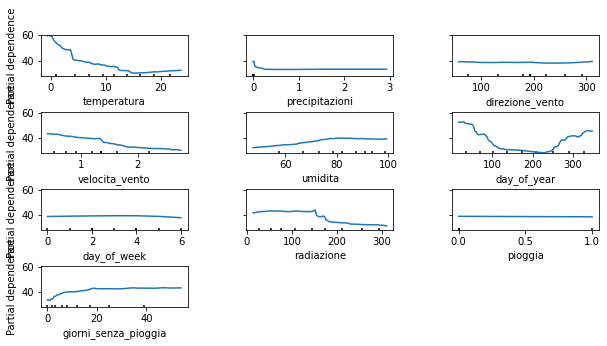

In [75]:
train_prec2 = norm_prec2.get_trainingset()

plot_partial_dependence(norm_prec2.get_model(), train_prec2, train_prec2.columns.drop("epoch"), )
fig = plt.gcf()
fig.subplots_adjust(wspace=0.4, hspace=0.9)

Dal grafico relativo alla variabile 'giorni_senza_pioggia' si nota in modo evidente come con l'aumentare del numero di giorni in cui non sono state registrate precipitazioni mediamente tenda ad aumentare anche la concentrazione dell'inquinante registrato.  

**Visti i risultati ottenuti dalle prove verrà modificata la funzione di preparazione dei dati per fare in modo che vengano inseriti anche i valori delle due nuove variabili.**

# Conclusioni #
Direi che a questo punto possiamo dire di aver delineato un framework da seguire per ottenere la normalizzazione dei dati sull'inquinamento. Con questo metodo potremo quindi procedere allo svolgimento delle analisi legate all'efficacia delle limitazioni imposte al traffico e all'influenza dell'epidemia di COVID sulle concentrazioni registrate.  
Anche per quanto riguarda la parte di codice ora abbiamo a disposizione tutte le funzioni di preparazione dati e generazione del modello di cui avremo bisogno.

In definitiva quindi le variabili utilizzate nel processo saranno (ovviamente in base anche a quelle che avremo a disposizione):
- Temperatura
- Precipitazioni
- Variabile booleana per indicare se si sono registrate precipitazioni
- Numero di giorni dalle ultime precipitazioni registrate
- Direzione del vento
- Velocità del vento
- Umidità
- Radiazione solare
- Data
- Giorno dell'anno
- Giorno della settimana

**Quando si potrà applicare questa tecnica?**  
Questa tecnica risulta particolarmente utile quando le analisi che si intendono compiere riguardano periodi estesi, per verificare l'andamento sul lungo termine delle concentrazioni e, ad esempio, verificare la presenza di trend. Risulta un approccio valido anche quando si vuole andare a verificare l'efficacia di eventuali limitazioni (permanenti o comunque a lungo termine) messe in atto, poichè risulta più facile identificare eventuali riscontri rispetto all'analisi dei dati grezzi.

A puro titolo esemplificativo sotto viene mostrato il grafico della timeseries normalizzata delle concentrazioni di PM10 registrate nella stazione di Milano via Senato, la linea verticale indica la data di introduzione di Area C. 

(Visto il grafico ottenuto ci sarà sicuramente da analizzare in modo molto più approfondito la questione Area C)

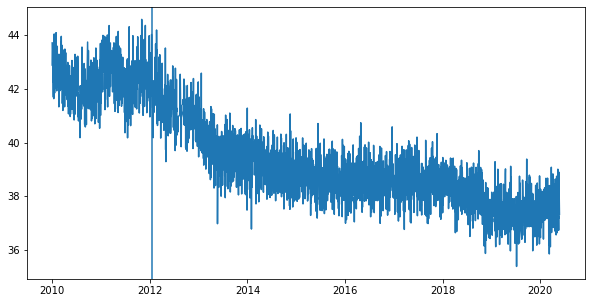

In [73]:
normalized_ts = norm_prec2.normalize_timeseries()
plt.plot(normalized_ts.index, normalized_ts.inquinante)
plt.axvline(dt.datetime(2012, 1, 16))
plt.show()

**In quali casi questa tecnica NON è applicabile?**  
Questa tecnica non risulta utile quando si vogliono fare analisi su brevi periodi, ad esempio di qualche giorno, o comunque in quelle situazioni in cui si è interessati a trattare la reale concentrazione misurata e non il dato normalizzato (es. per verificare l'efficacia dei blocchi del traffico di pochi giorni).